# Earthquake_real
> Non-Euclidean geometry

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA, eigenvalue deposition]

In [803]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import folium
from IPython.display import HTML

In [1248]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

**대지진 순위중 일부 추출**

In [883]:
pd.read_html('https://ko.wikipedia.org/wiki/%EC%A7%80%EC%A7%84_%EB%AA%A9%EB%A1%9D',encoding='utf-8')[1].iloc[[2,3,8],:]

,순위,일자,장소,이름,규모
2,3,2004년 12월 26일,인도네시아 수마트라섬,2004년 인도양 지진 해일,9.1-9.3
3,4,2011년 3월 11일,일본 산리쿠 해역,2011년 도호쿠 지방 태평양 앞바다 지진,9.1
8,6 (공동),2010년 2월 27일,칠레 마울레주 해역,2010년 칠레 지진,8.8


- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

##### 1. 데이터 정의

In [885]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year=="2004" | Year=="2010" | Year=="2011"').reset_index().iloc[:,1:]
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1843 entries, 0 to 1842
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1843 non-null   object 
 1   Latitude   1843 non-null   float64
 2   Longitude  1843 non-null   float64
 3   Magnitude  1843 non-null   float64
 4   Year       1843 non-null   object 
dtypes: float64(3), object(2)
memory usage: 72.1+ KB


<AxesSubplot:>

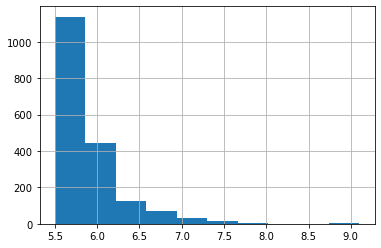

In [719]:
_df.Magnitude.hist()

##### 2. $f(x) = y$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [720]:
f = _df.loc[:,"Magnitude"]

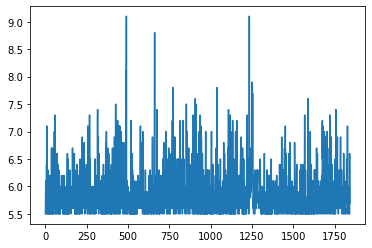

In [721]:
#collapse
plt.plot(f,'-')

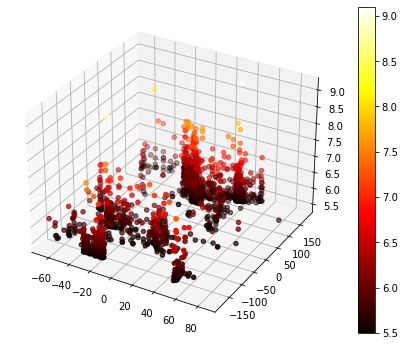

In [722]:
#collapse
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(_df.Latitude, _df.Longitude, _df.Magnitude, c= _df.Magnitude,  cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [723]:
#collapse
lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2011-2010)]

In [724]:
#collapse
from folium import plugins 
data=(np.random.normal(size=(100,3)) + np.array([[28,77,5]])).tolist() # (좌표,weight)를 의미함, 그리고 numpy는 list가 될 수 없기 때문에 tolist 옵션 사용
m=folium.Map([28,77],zoom_start=6,scrollWheelZoom=False)
plugins.HeatMap(data).add_to(m) 

In [725]:
#collapse
m=folium.Map(scrollWheelZoom=False)
plugins.HeatMapWithTime(lst,radius=5,index=list(range(2010,2011))).add_to(m)
m

##### 3. 비유클리드 공간에서의 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의
- 지진의 영향이 주변에만 끼치는 것을 고려하여 경도, 위도의 차이가 90도 이내인 경우만 거리 계산

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{(x_j-x_i)^2+(y_j-y_i)^2}$$

In [1342]:
def dist(i,j):
    a1=abs(_df.Latitude[j] - _df.Latitude[i])
    a2=abs(_df.Latitude[j] + _df.Latitude[i])
    b1=abs(_df.Longitude[j] - _df.Longitude[i])
    b2=abs(_df.Longitude[j] + _df.Longitude[i])
    a= np.min([a1,a2])
    b= np.min([b1,b2])
    return np.sqrt(a**2+b**2)

---

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/8390236068c8e84f9fea2729c76a21ec3574a7db)

In [1298]:
from haversine import haversine

In [1299]:
def dist(i,j):
    return haversine((_df.Latitude[i],_df.Longitude[i]),(_df.Latitude[j],_df.Longitude[j]))

In [1301]:
def weight(i,j,theta=100000,kappa=100000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

---

##### 4. 거리를 이용한 a weighted adjacency matrix $W_{i,j}$ 정의

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [1261]:
def weight(i,j,theta=90,kappa=1000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [1302]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

(array([   9558.,   51010.,  192884.,  157606.,  153462.,  214466.,
         272642.,  398032.,  620450., 1326539.]),
 array([0.98020684, 0.98218616, 0.98416547, 0.98614479, 0.98812411,
        0.99010342, 0.99208274, 0.99406205, 0.99604137, 0.99802068,
        1.        ]),
 <BarContainer object of 10 artists>)

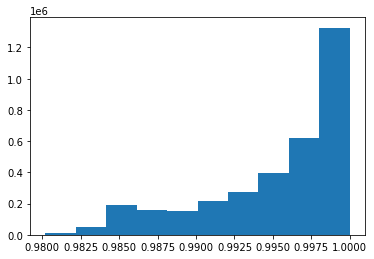

In [1303]:
#collapse
plt.hist(W.reshape(-1))

##### 5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [1304]:
D = np.diag(W.sum(axis=1))

In [1305]:
D

array([[1837.17287446,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        , 1835.69798283,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        , 1831.67916547, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 1837.24069113,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        1833.71008718,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 1833.82480814]])

##### 6. Graph Laplacian matrix 정의
- $L = D - W$

In [1306]:
L = D - W

In [1307]:
L

array([[ 1.83617287e+03, -9.98224541e-01, -9.94403394e-01, ...,
        -9.99995982e-01, -9.94151553e-01, -9.98481948e-01],
       [-9.98224541e-01,  1.83469798e+03, -9.87477105e-01, ...,
        -9.98308102e-01, -9.97585667e-01, -9.95075998e-01],
       [-9.94403394e-01, -9.87477105e-01,  1.83067917e+03, ...,
        -9.94359222e-01, -9.92673589e-01, -9.95854604e-01],
       ...,
       [-9.99995982e-01, -9.98308102e-01, -9.94359222e-01, ...,
         1.83624069e+03, -9.94446980e-01, -9.98322983e-01],
       [-9.94151553e-01, -9.97585667e-01, -9.92673589e-01, ...,
        -9.94446980e-01,  1.83271009e+03, -9.86783310e-01],
       [-9.98481948e-01, -9.95075998e-01, -9.95854604e-01, ...,
        -9.98322983e-01, -9.86783310e-01,  1.83282481e+03]])

##### 7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [1308]:
λ, Ψ = np.linalg.eig(L)

In [1309]:
Λ = np.diag(λ)

##### 8. 주성분 분석
- $compk = f @ np.outer(Ψ[:,k], Ψ[:,k]) $
    - $k = 1, 2, 3, 8000$
- $p = \sum_{1}^{n} comp1^2,\sum_{1}^{n} comp2^2,…,\sum_{1}^{n} compn^2$
- $p = \frac{p}{\sum(p)}$

In [1310]:
def comp(i):
    return (f @ np.outer( Ψ[:,i], Ψ[:,i]))

In [1311]:
def p(i):
    return sum(comp(i)**2)

In [1312]:
array_1 = np.array([p(i) for i in range(1,len(_df))])

In [1313]:
varprop = array_1/array_1.sum()

In [1314]:
#collapse
_index = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop}).sort_values('varprop',ascending=False)
_indexlst = _index.iloc[:25,0].tolist()

In [1315]:
#collapse_output
_indexlst

[609,
 1830,
 348,
 526,
 1702,
 1833,
 1558,
 866,
 1747,
 1185,
 563,
 1812,
 1450,
 1779,
 680,
 429,
 1139,
 285,
 490,
 759,
 1786,
 1284,
 586,
 1660,
 1318]

(0.0, 40.0)

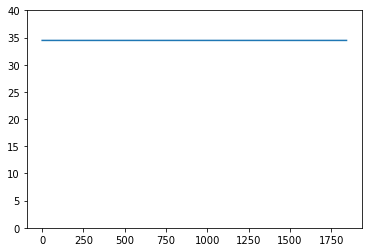

In [1316]:
plt.plot( (f @ np.outer( Ψ[:,0], Ψ[:,0]))**2)
plt.ylim(0,40)

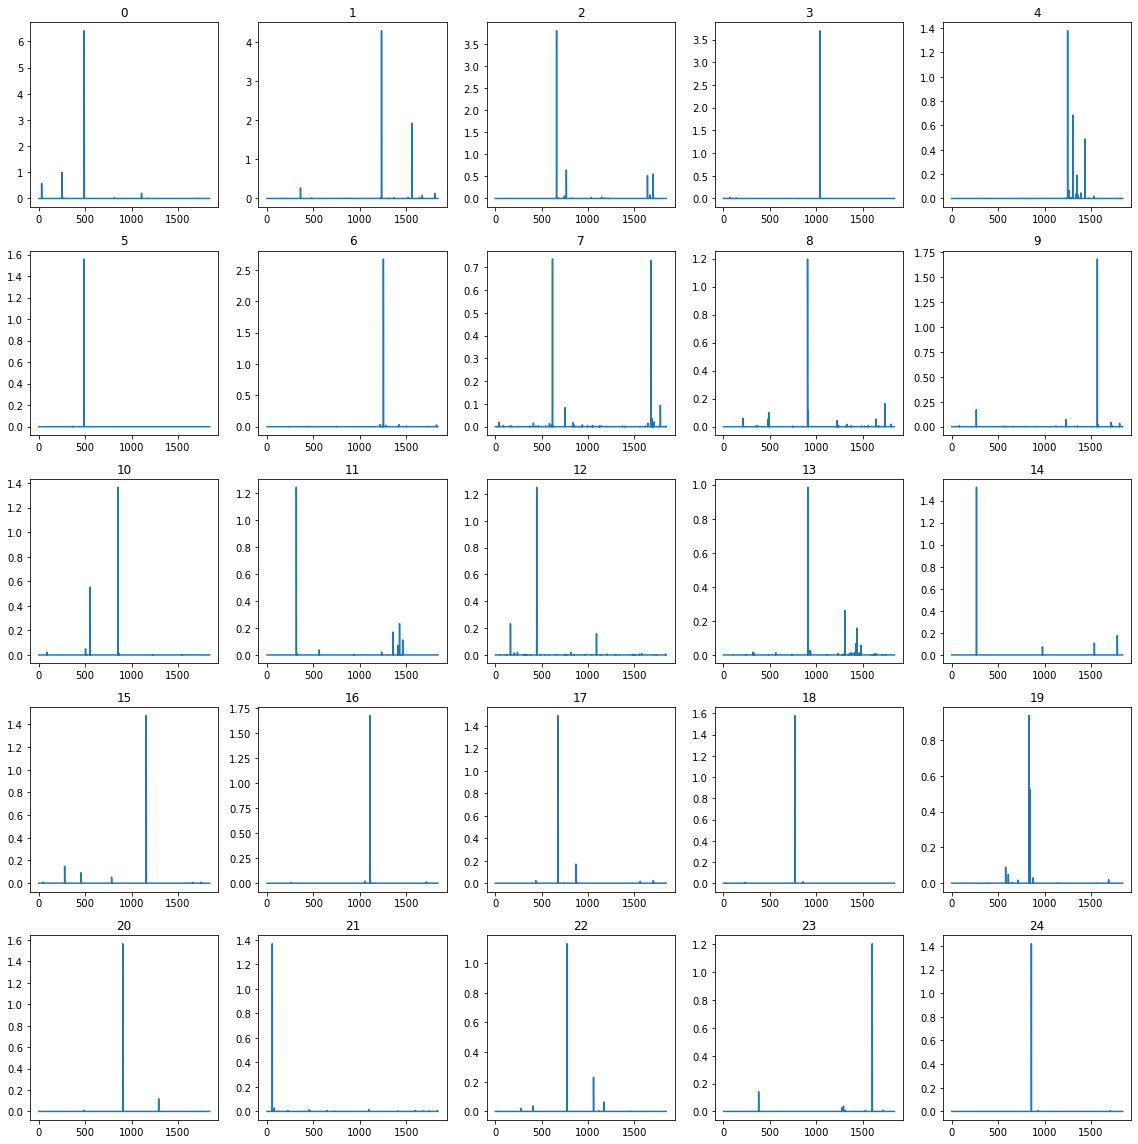

In [1317]:
fig,ax =plt.subplots(5,5)
k=0
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,_indexlst[k]], Ψ[:,_indexlst[k]]))**2)
        # ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

##### 9. PCA

In [1318]:
comp1 = f @ np.outer( Ψ[:,0], Ψ[:,0])

In [1319]:
comp2 = f @ np.outer( Ψ[:,_indexlst[0]], Ψ[:,_indexlst[0]])

In [1320]:
comp3 = f @ np.outer( Ψ[:,_indexlst[1]], Ψ[:,_indexlst[1]])

In [1321]:
comp4 = f @ np.outer( Ψ[:,_indexlst[2]], Ψ[:,_indexlst[2]])

In [1322]:
comp5 = f @ np.outer( Ψ[:,_indexlst[3]], Ψ[:,_indexlst[3]])

In [1323]:
_df["comp1"] = comp1

In [1324]:
_df["comp2"] = comp2

In [1325]:
_df["comp3"] = comp3

In [1326]:
_df["comp4"] = comp4

In [1327]:
_df["comp5"] = comp5

---

해본 거 중 별로
- 𝑑𝑖𝑠𝑡 를 이용한 𝜃 = 75, 𝜅 = 1000
- ℎ𝑎𝑣𝑒𝑟𝑠𝑖𝑛𝑒 패키지를 이용한 𝜃 = 25000,𝜅 = 100000

---

##### **$dist$를 이용한 $\theta$ = 80, $\kappa$ = 1000**

In [1084]:
_G = nx.Graph(W-np.identity(len(f)))

In [1085]:
_pos = nx.spring_layout(_G,iterations=20)

In [1086]:
m_pos = list(zip(_df.Longitude,_df.Latitude))

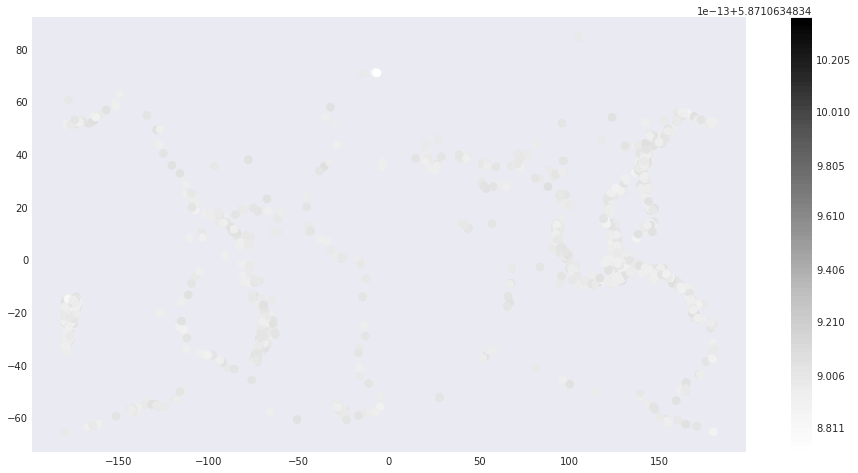

In [1087]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp1,node_size = abs(_df.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

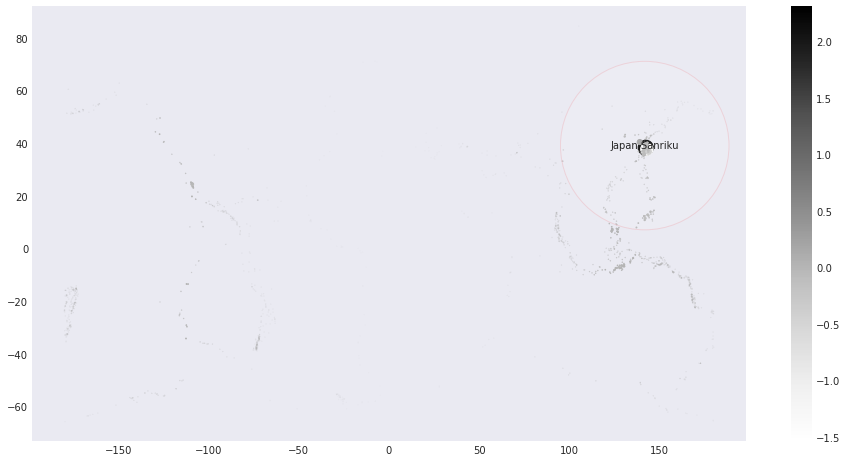

In [1092]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp2,node_size = np.abs(_df.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

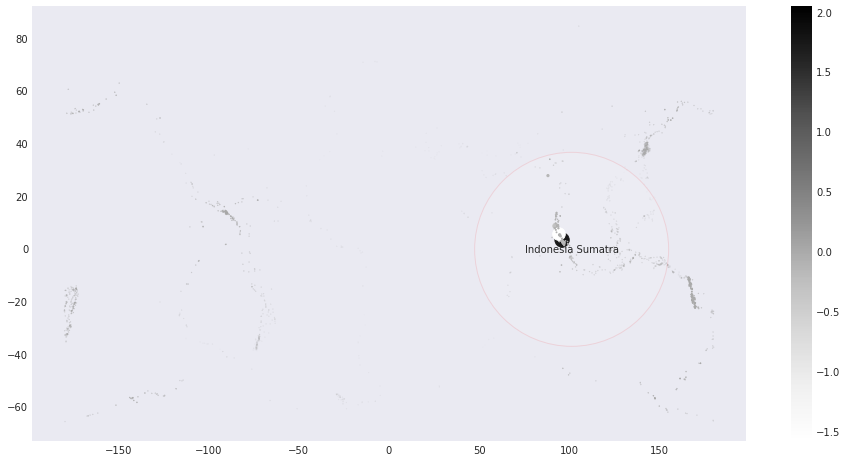

In [1093]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp3,node_size = np.abs(_df.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

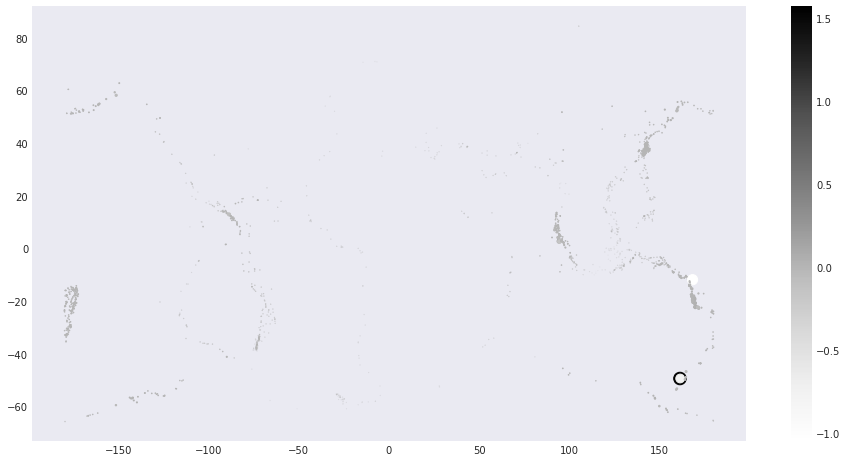

In [1095]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp4,node_size = np.abs(_df.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

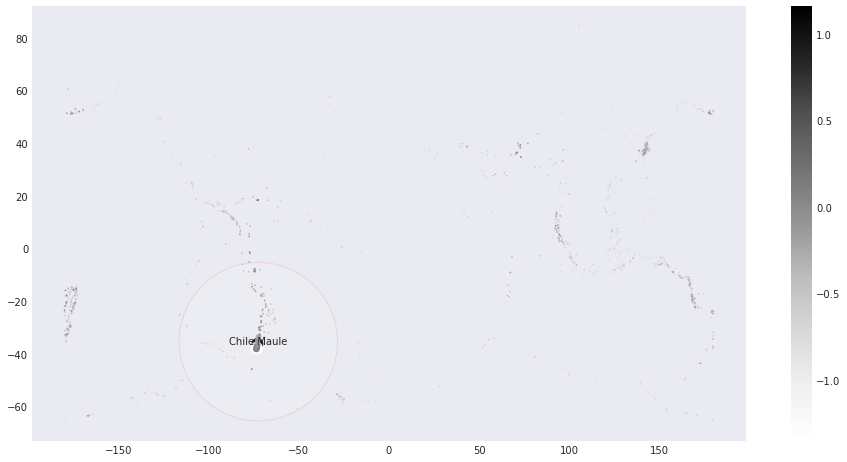

In [1094]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp5,node_size = abs(_df.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$dist$를 이용한 $\theta$ = 85, $\kappa$ = 1000**

In [1230]:
_G = nx.Graph(W-np.identity(len(f)))

In [1231]:
_pos = nx.spring_layout(_G,iterations=20)

In [1232]:
m_pos = list(zip(_df.Longitude,_df.Latitude))

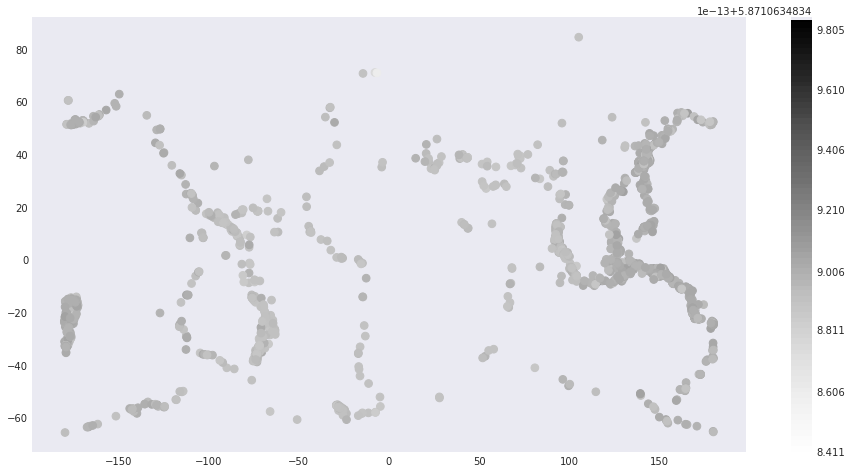

In [1233]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp1,node_size = abs(_df.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

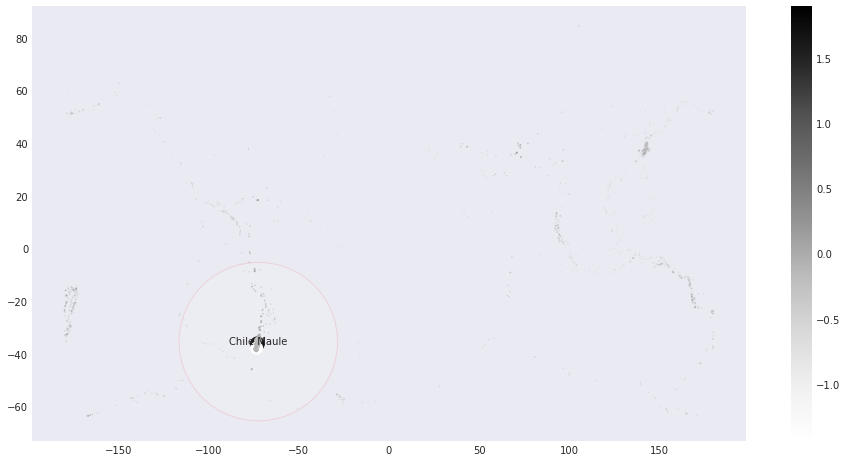

In [1238]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp2,node_size = np.abs(_df.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

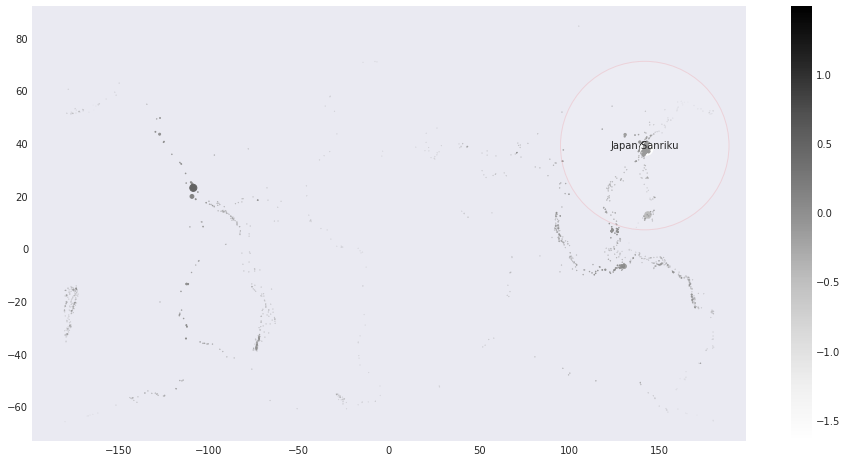

In [1240]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp3,node_size = np.abs(_df.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

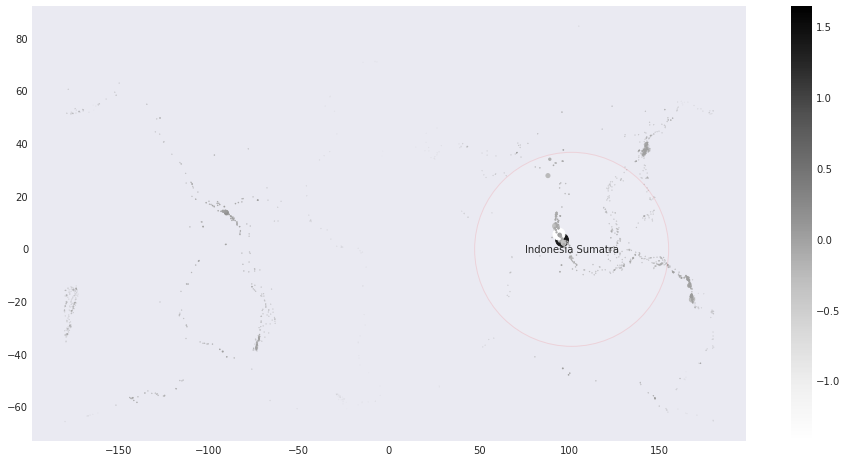

In [1241]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp4,node_size = np.abs(_df.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

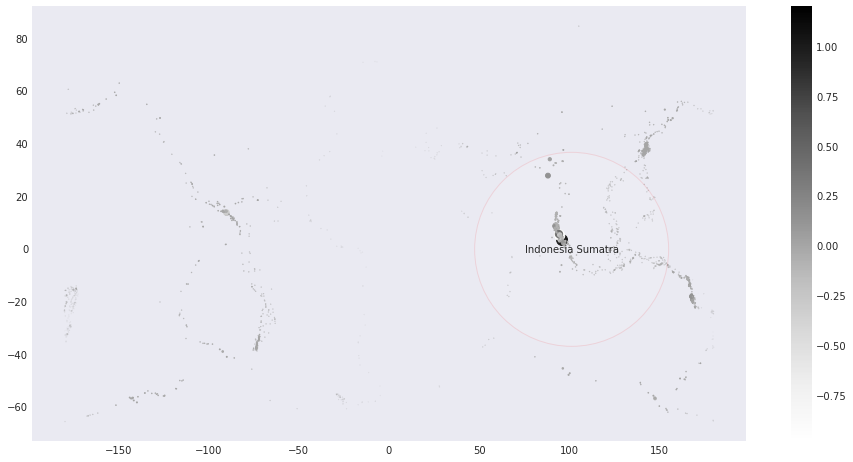

In [1242]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp5,node_size = abs(_df.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$dist$를 이용한 $\theta$ = 90, $\kappa$ = 1000**

In [1288]:
_G = nx.Graph(W-np.identity(len(f)))

In [1289]:
_pos = nx.spring_layout(_G,iterations=20)

In [1290]:
m_pos = list(zip(_df.Longitude,_df.Latitude))

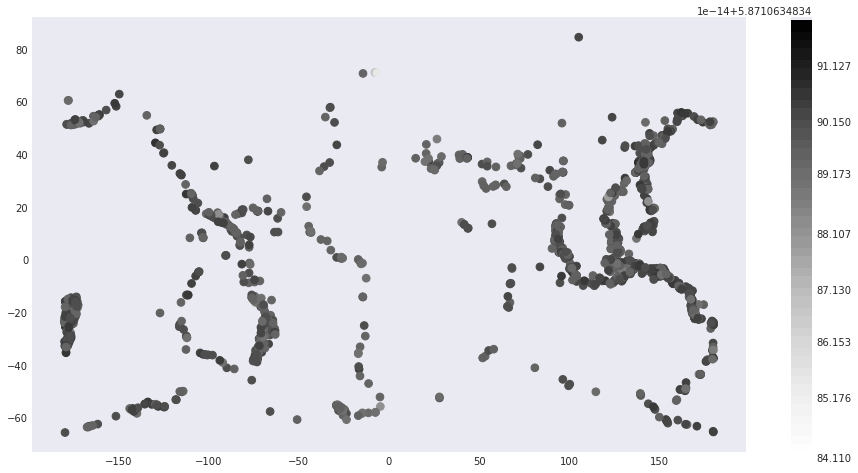

In [1291]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp1,node_size = abs(_df.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

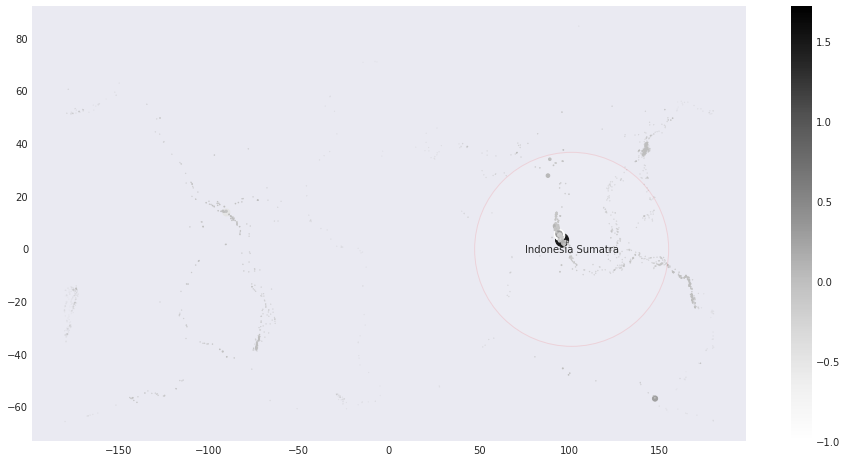

In [1297]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp2,node_size = np.abs(_df.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

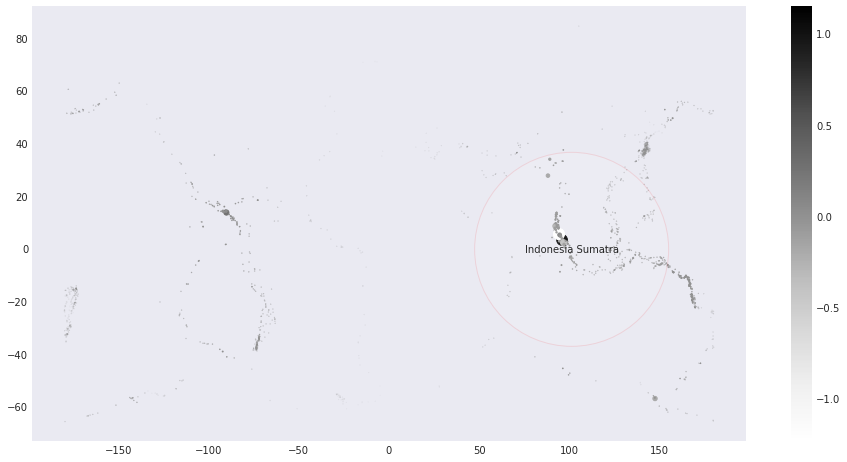

In [1293]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp3,node_size = np.abs(_df.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

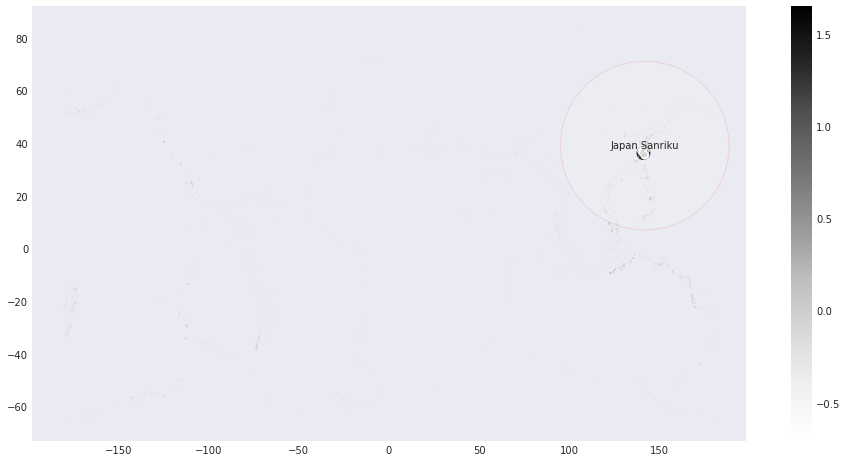

In [1296]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp4,node_size = np.abs(_df.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

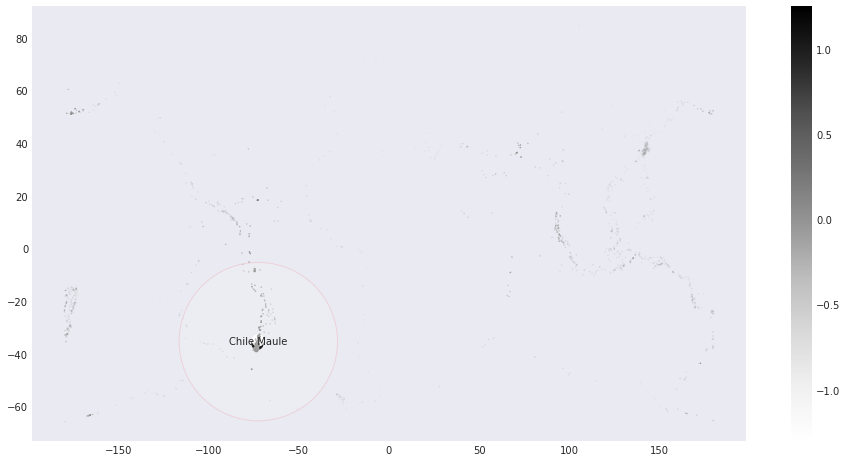

In [1295]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp5,node_size = abs(_df.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$haversine$ 패키지를 이용한 $\theta$ = 50000,$\kappa$ = 100000**

In [1002]:
_G = nx.Graph(W-np.identity(len(f)))

In [1003]:
_pos = nx.spring_layout(_G,iterations=20)

In [1004]:
m_pos = list(zip(_df.Longitude,_df.Latitude))

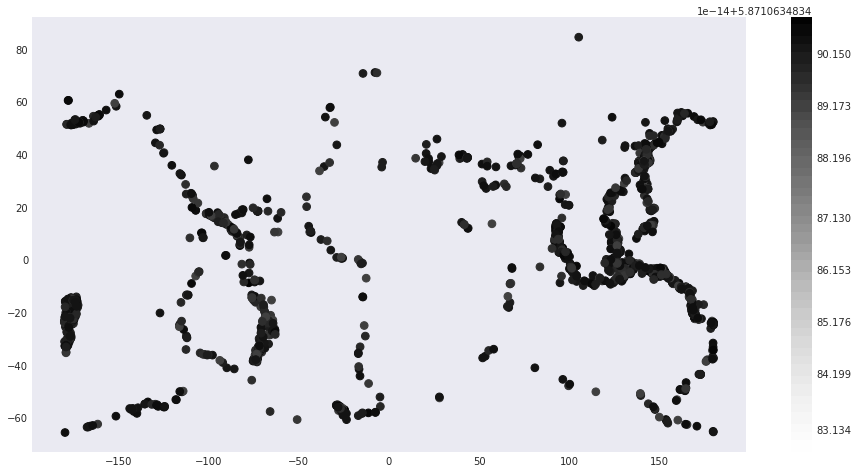

In [1005]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp1,node_size = abs(_df.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

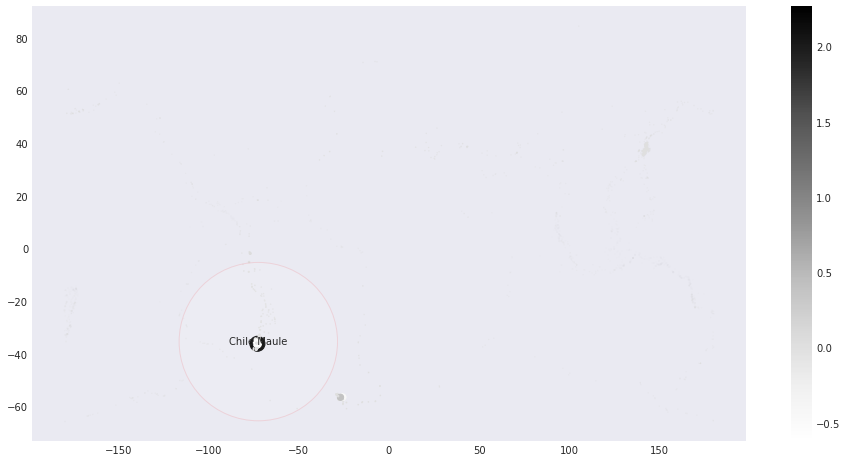

In [1010]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp2,node_size = np.abs(_df.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

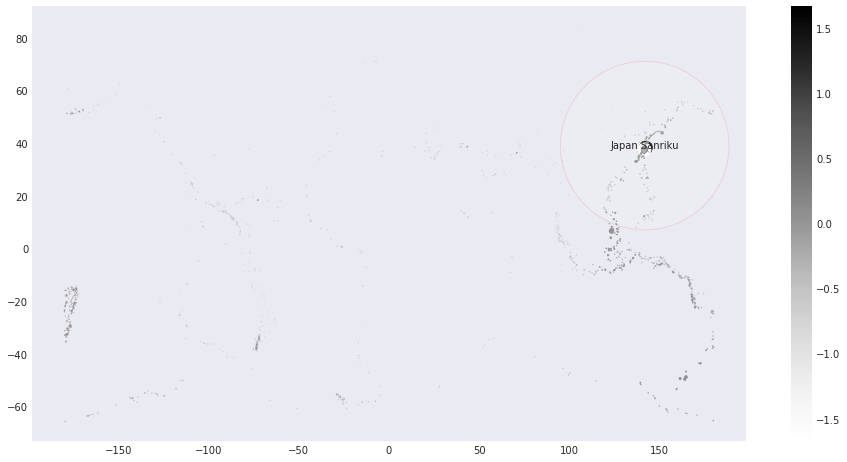

In [1012]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp3,node_size = np.abs(_df.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

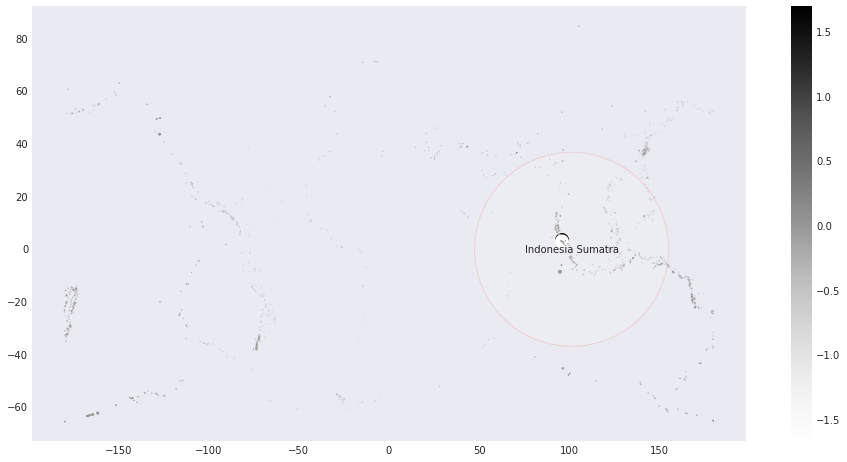

In [1011]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp4,node_size = np.abs(_df.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

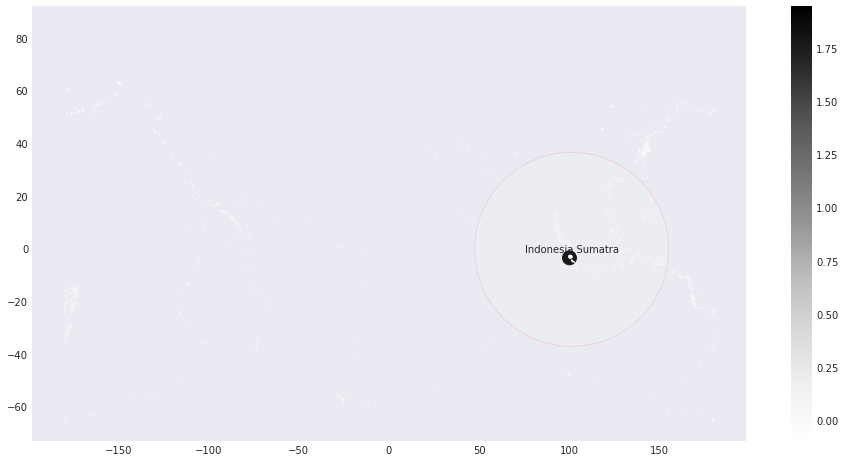

In [1013]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp5,node_size = abs(_df.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    # ax.annotate("Tasman Sea", xy=(160.4313,-40.8581), xycoords="data",
    #               va="center", ha="center",
    #               bbox=dict(boxstyle="circle, pad=3", alpha = 0.1,fc="w",lw=1, ec='r'))
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$haversine$ 패키지를 이용한 $\theta$ = 75000,$\kappa$ = 100000**

In [1189]:
_G = nx.Graph(W-np.identity(len(f)))

In [1190]:
_pos = nx.spring_layout(_G,iterations=20)

In [1191]:
m_pos = list(zip(_df.Longitude,_df.Latitude))

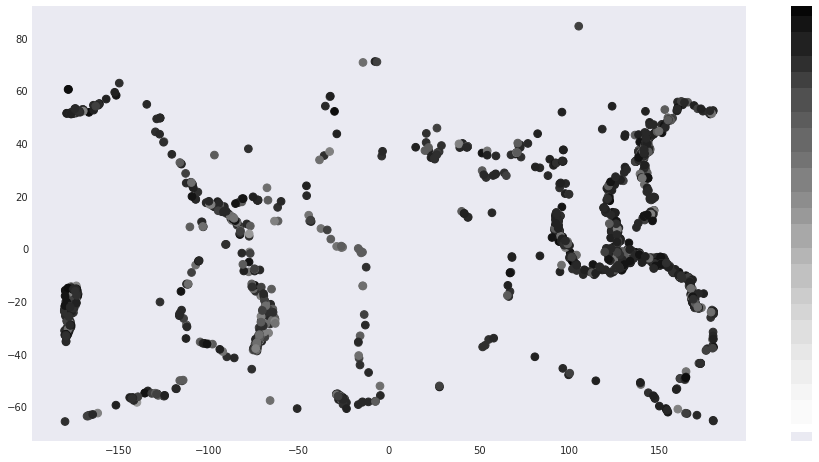

In [1192]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp1,node_size = abs(_df.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

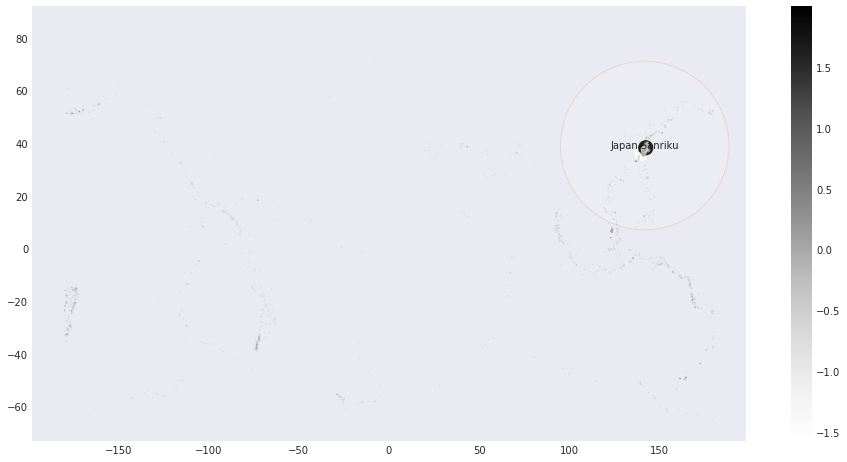

In [1198]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp2,node_size = np.abs(_df.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

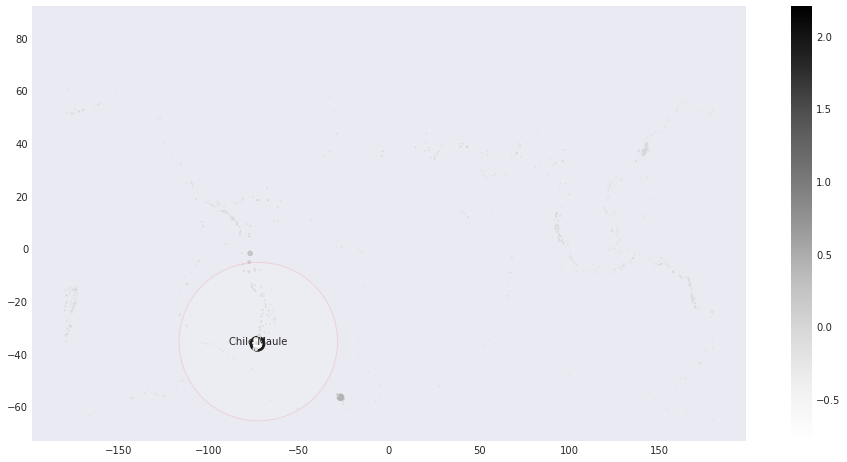

In [1199]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp3,node_size = np.abs(_df.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

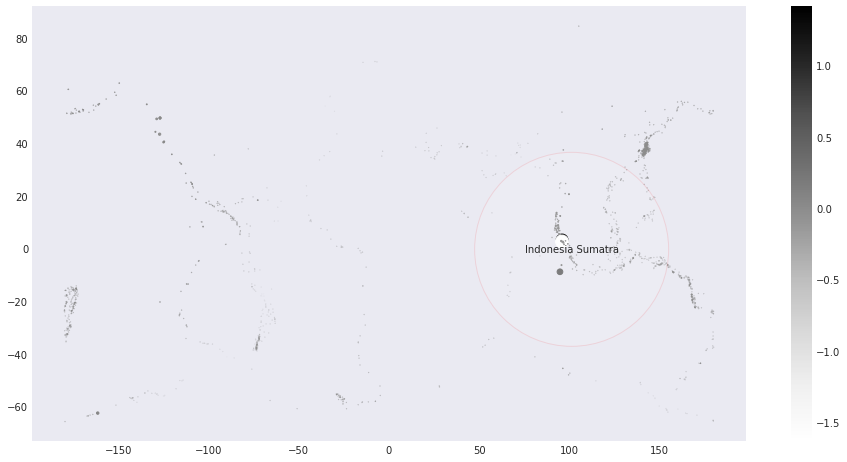

In [1201]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp4,node_size = np.abs(_df.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

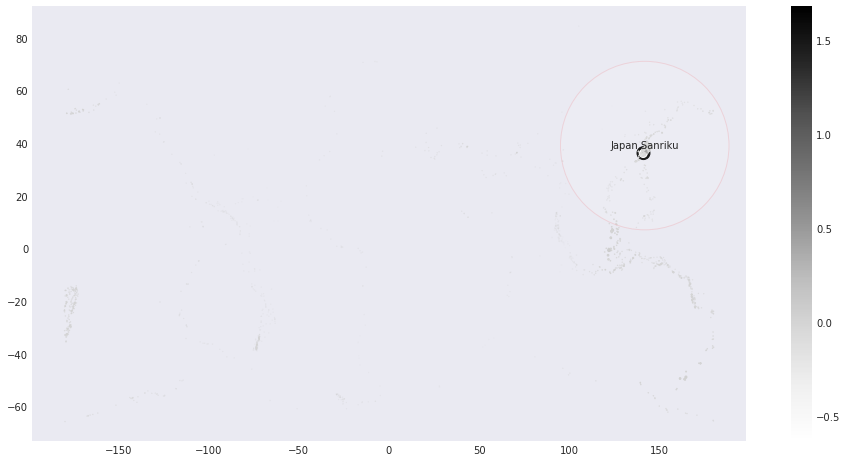

In [1200]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp5,node_size = abs(_df.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    # ax.annotate("Tasman Sea", xy=(160.4313,-40.8581), xycoords="data",
    #               va="center", ha="center",
    #               bbox=dict(boxstyle="circle, pad=3", alpha = 0.1,fc="w",lw=1, ec='r'))
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$haversine$ 패키지를 이용한 $\theta$ = 100000,$\kappa$ = 100000**

In [1328]:
_G = nx.Graph(W-np.identity(len(f)))

In [1329]:
_pos = nx.spring_layout(_G,iterations=20)

In [1330]:
m_pos = list(zip(_df.Longitude,_df.Latitude))

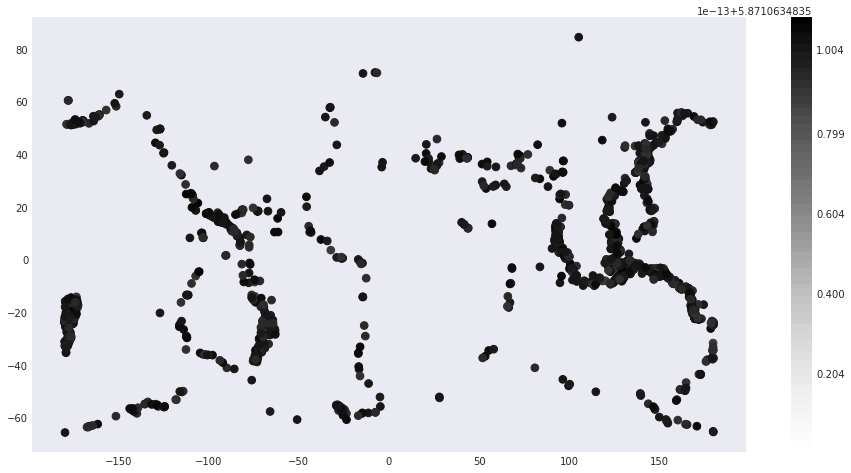

In [1331]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp1,node_size = abs(_df.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

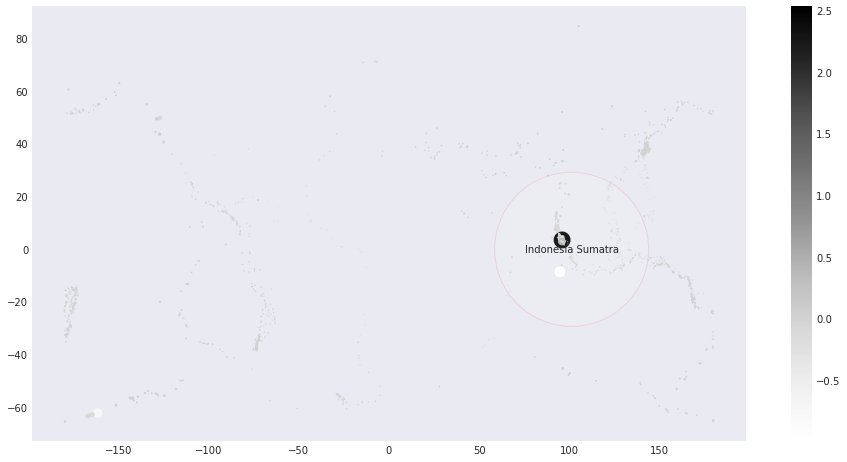

In [1341]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp2,node_size = np.abs(_df.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=3", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

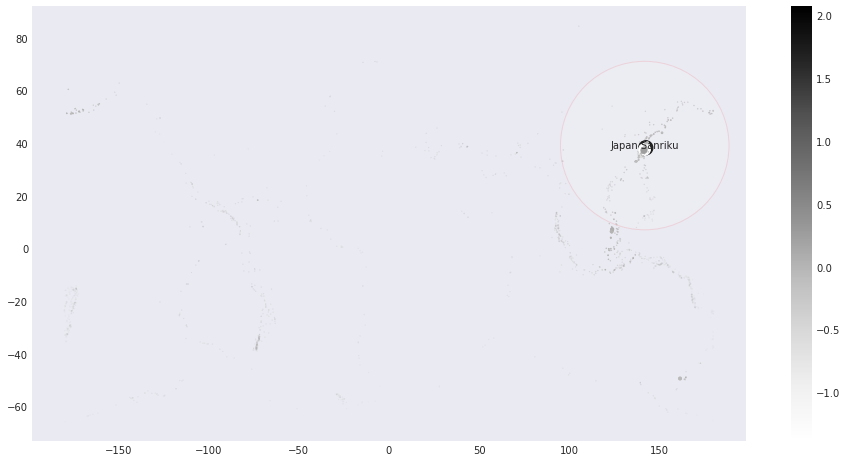

In [1337]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp3,node_size = np.abs(_df.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

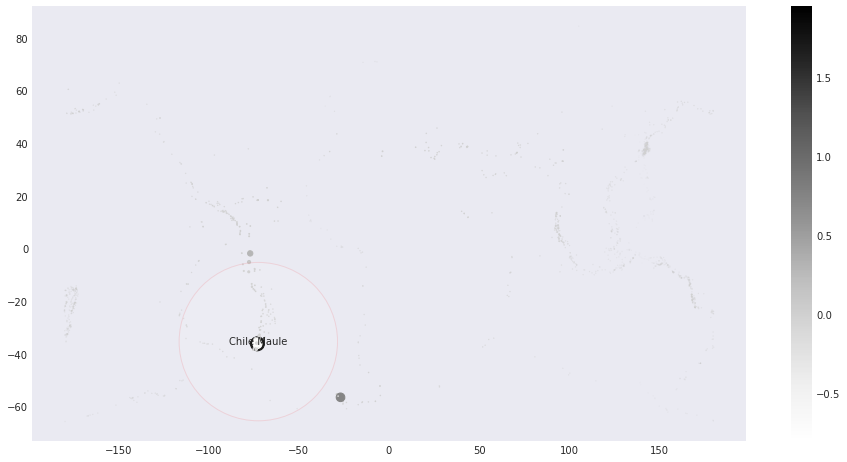

In [1338]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp4,node_size = np.abs(_df.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

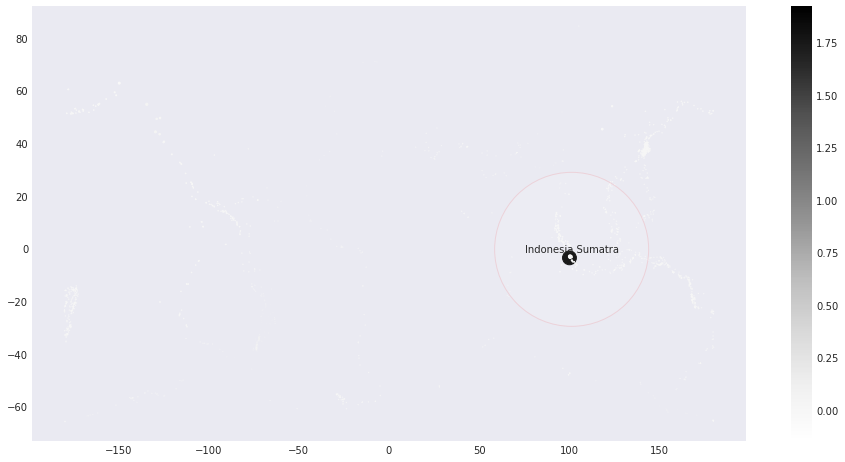

In [1340]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp5,node_size = abs(_df.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=3", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---